In [1]:
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import chi2_contingency
from argparse import ArgumentParser
from cellrank.estimators import GPCCA
import matplotlib.pyplot as plt
import scanpy.external as sce
import scrublet as scr
import seaborn as sns
import cellrank as cr
import scvelo as scv
import pandas as pd
import scanpy as sc
import numpy as np
import scipy.sparse
import collections
import matplotlib
#import pyBigWig
#import networkx
#import pyscenic
import requests
#import network
#import fsspec
import anndata
#import igraph
import os
import pysam
import scvi
import h5py
import desc 
import umap
import sys
import re


%load_ext rpy2.ipython
%matplotlib inline 
sc.settings.verbosity = 3     
np.random.seed(42)

plt.rcParams.update({'font.size': 9})
sc.set_figure_params(figsize=(2, 2), format = 'svg', dpi_save = 300)


Global seed set to 0
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


... reading from cache file cache/Users-brendamelano-Desktop-10xver7-OS152-OS152.h5ad


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/utils.py:111: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


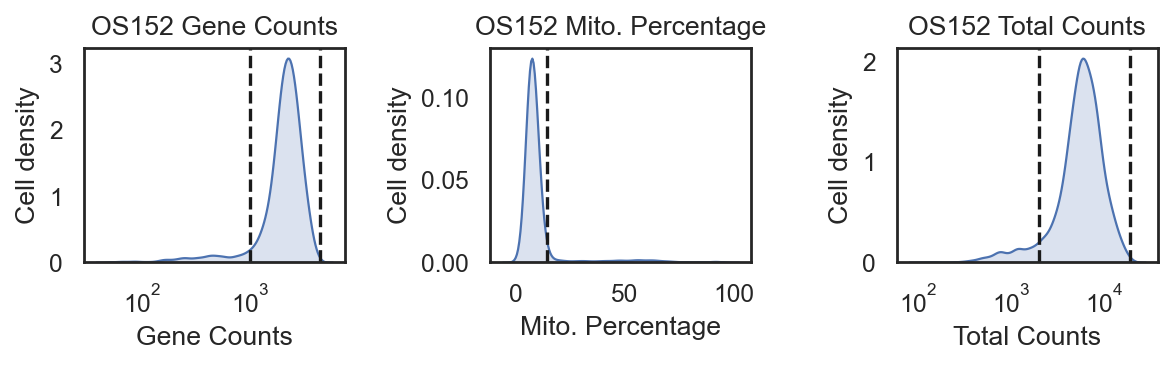

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/core/_anndata.py:610: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[f"initial_size_{layer}"] = get_size(adata, layer)
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])


Filtered out 53542 genes that are detected 20 counts (shared).


In [2]:
# Reading in loom files
adata = scv.read('/Users/brendamelano/Desktop/10xver7/OS152/OS152.loom', cache = True)


# Ensuring that all variable names are unique
adata.var_names_make_unique()


# Identifying mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-') 


# Computing mitochondrial percentage and other QC metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


# Assigning thresholds for QC variables
variables = [
    ('n_genes_by_counts', [(4500, '--'), (1000, '--')]),
    ('pct_counts_mt', [(14, '--')]),
    ('total_counts', [(2000, '--'), (19000, '--')])
]


# Creating dictionary for QC variables
titles = {
    'n_genes_by_counts': 'Gene Counts',
    'pct_counts_mt': 'Mito. Percentage',
    'total_counts': 'Total Counts'
}


# Setting the theme without gridlines
sns.set_theme(style="white")


# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(7.5, 2.5))


# Iterating over the QC variables and their respective thresholds
for ax, (var, lines) in zip(axes, variables):
    
    sns.kdeplot(data=adata.obs, x=var, fill=True, alpha=0.2, ax=ax,
                log_scale=True if var != 'pct_counts_mt' else False)
    for line, style in lines:
        ax.axvline(x=line, color='k', linestyle=style)
    ax.set_title(f"OS152 {titles[var]}")  
    ax.set_xlabel(titles[var]) 
    ax.set_ylabel("Cell density")


# Adjust layout to prevent overlap
plt.tight_layout()


# Save the figure as SVG
#plt.savefig("/Users/brendamelano/Desktop/OS152_filtering_plain.svg")


# Show the plot
plt.show()


# Filtering the adata set based on total counts, genes and mitochondrial percentage
adata = adata[(adata.obs['total_counts'] >= 2000) &
                        (adata.obs['total_counts'] <= 19000) &
                        (adata.obs['n_genes_by_counts'] >= 1000) &
                        (adata.obs['n_genes_by_counts'] < 4500) & 
                        (adata.obs['pct_counts_mt'] < 14)
                        ]


# Filtering genes based on minimum counts 
scv.pp.filter_genes(adata, min_shared_counts=20)


# Normalizing the cells by all counts across all the genes
scv.pp.normalize_per_cell(adata)


# Log transformating the counts
scv.pp.log1p(adata)


# Preserving the counts
adata.layers["counts"] = adata.X.copy() 


# Freezing the data in raw
# try moving to after selecting highly variable genes
adata.raw = adata


# Creating a df with the indexes (CellIDs from the adata object)
sample_one_index = pd.DataFrame(adata.obs.index)


# Selecting highly variable genes
# Research all the possible parameters for this
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000, 
    subset=True,
    layer="counts" #min_mean=0.0125, max_mean=3, min_disp=0.5
)


# Making a variable for the gene names
genes = adata.var.index.values


# Make sure this shouldn't come after the scale
cell_cycle_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/scvi/regev_lab_cell_cycle_genes.txt')]


# Split into s and g2m lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]


# Saving object for cell cycle genes based on those in adata
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]


# Scoring the cell cycle
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)


# Computing the ccdifference score
adata.obs['ccdifference'] = adata.obs['S_score'] - adata.obs['G2M_score']


#adata.raw = adata
adata = adata[:, adata.var.highly_variable]


# Regressing out total couts, mitochondrial percentage and ccdifference scores
sc.pp.regress_out(adata, ['n_counts', 'pct_counts_mt', 'ccdifference'])
                    
                    
# Scaling the data 
sc.pp.scale(adata, max_value=10)


# Performing principal component analysis
sc.tl.pca(adata, svd_solver='arpack')


# Identifying neighbors for umap
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=30)


# Performing UMAP analysis
sc.tl.umap(adata)


# Leiden clustering
sc.tl.leiden(adata, resolution = 0.6)


# Plotting the UMAP
sc.pl.umap(
    adata,
    color=["leiden"],
    frameon=True,
    title="OS152 Clusters",
    size=20,
    show=False  # Do not display the plot immediately
)


# Save the plot as an SVG file
#plt.savefig("/Users/brendamelano/Desktop/OS152_clusters.svg", format='svg')
plt.show()  



In [4]:

# saving the adata file with the cluster ids
adata.write("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS152/OS152_adata_leiden_PCA.h5ad")



# Reading in cluster labeled data

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


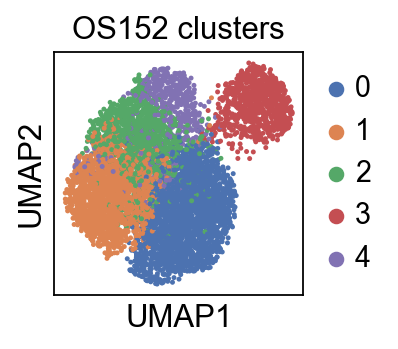

In [7]:
# Reading in the adata file from the subtype data
adata = scv.read("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS152/OS152_adata_leiden_PCA.h5ad")


# Plot the UMAP
sc.pl.umap(
    adata,
    color=["leiden"],
    frameon=True,
    title="OS152 clusters",
    size=20,
    show=False  # Do not display the plot immediately
)


# Rasterize the scatter plot elements only
ax = plt.gca()
for artist in ax.get_children():
    if isinstance(artist, mc.PathCollection): 
        artist.set_rasterized(True)

        
# Save as an SVG with rasterized points
#plt.savefig("/Users/brendamelano/Desktop/OS384_pert_clusters_rasterized.svg", format='svg')
plt.show()

In [5]:
import matplotlib.collections as mc

# Reading in the state labeled adata object

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'OS152 States'}, xlabel='UMAP1', ylabel='UMAP2'>

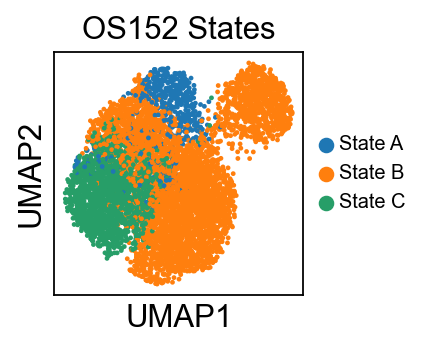

In [2]:
# Reading in the adata file from the subtype data
adata = scv.read("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS152/OS152_adata_subtype_PCA.h5ad")


# Plotting the UMAP
sc.pl.umap(adata, 
           color=['State'], 
           legend_fontsize=9, 
           title="OS152 States",
           show=False)  


# Saving the figure to Desktop
#plt.savefig('/Users/brendamelano/Desktop/UMAP_OS152_State.svg', format='svg', dpi=300)


# Reading in cluster labeled data

In [2]:
adata = sc.read(f"/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS152/OS152_adata_leiden_PCA.h5ad")



# Preparing files for MAVE and CiberATAC

In [3]:
adata.write_h5ad('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/Brenda_data_for_Mehran/h5_files/152_raw_filtered_feauture_bc_matrix.h5')



AnnData object with n_obs × n_vars = 6490 × 7999
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'
                         n_genes_by_counts  total_counts  total_counts_mt  \
CellID                                                                      
OS152:AAACGCTGTACCCGCAx               1617        3565.0            222.0   
OS152:AAACCCAAGGCTCACCx               3098        9869.0            579.0   
OS152:AACAAAGGTGTGTTTGx               2627        7867.0            581.0   
OS152:AAAGGGCCAGTTGTCAx               1641        3664.0            211.0   
OS152:AAAGGGCTCTCCAAGAx               2262        5938.0            326.0   

                         pct_counts_mt  initial_size_unspliced

In [5]:

file_path = '/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/Brenda_data_for_Mehran/h5_files/152_raw_filtered_feauture_bc_matrix.h5'


# Read the AnnData object
adata = sc.read_h5ad(file_path)



if isinstance(adata.X, scipy.sparse.spmatrix):
    print("adata.X is a sparse matrix.")
    print("Number of non-zero entries:", adata.X.nnz)
    print("Data array:", adata.X.data)
    print("Indices:", adata.X.indices)
    print("Index pointer:", adata.X.indptr)
else:
    print("adata.X is not a sparse matrix.")

AnnData object with n_obs × n_vars = 6490 × 7999
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'
                         n_genes_by_counts  total_counts  total_counts_mt  \
CellID                                                                      
OS152:AAACGCTGTACCCGCAx               1617        3565.0            222.0   
OS152:AAACCCAAGGCTCACCx               3098        9869.0            579.0   
OS152:AACAAAGGTGTGTTTGx               2627        7867.0            581.0   
OS152:AAAGGGCCAGTTGTCAx               1641        3664.0            211.0   
OS152:AAAGGGCTCTCCAAGAx               2262        5938.0            326.0   

                         pct_counts_mt  initial_size_unspliced

# generating files for rds file

In [14]:
import scanpy as sc
import pandas as pd
import numpy as np
from scipy import sparse
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

# Activate automatic pandas to R DataFrame conversion
pandas2ri.activate()


# Define the file path to h5ad file
file_path = "/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/Brenda_data_for_Mehran/h5_files/152_raw_filtered_feauture_bc_matrix.h5"


# Read the AnnData object
adata = sc.read_h5ad(file_path)


# Extract the count matrix, cell barcodes, and gene names
count_matrix = adata.X
cell_barcodes = adata.obs_names
gene_names = adata.var_names


from scipy.io import mmwrite


# Save the count matrix in Matrix Market format
mmwrite('/Users/brendamelano/Desktop/plain_scRNAseq_analysis/files_for_rds_generation/OS152_count_matrix.mtx', count_matrix)


# Save cell barcodes and gene names
cell_barcodes.to_series().to_csv('/Users/brendamelano/Desktop/plain_scRNAseq_analysis/files_for_rds_generation/OS152_barcodes.tsv', sep='\t', index=False, header=False)
gene_names.to_series().to_csv('/Users/brendamelano/Desktop/plain_scRNAseq_analysis/files_for_rds_generation/OS152genes.tsv', sep='\t', index=False, header=False)

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:261: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


# State module enrichment

computing score 'State_A_score'
    finished: added
    'State_A_score', score of gene set (adata.obs).
    99 total control genes are used. (0:00:00)
computing score 'Subtype_B_score'
    finished: added
    'Subtype_B_score', score of gene set (adata.obs).
    248 total control genes are used. (0:00:00)
computing score 'Subtype_C_score'
    finished: added
    'Subtype_C_score', score of gene set (adata.obs).
    49 total control genes are used. (0:00:00)


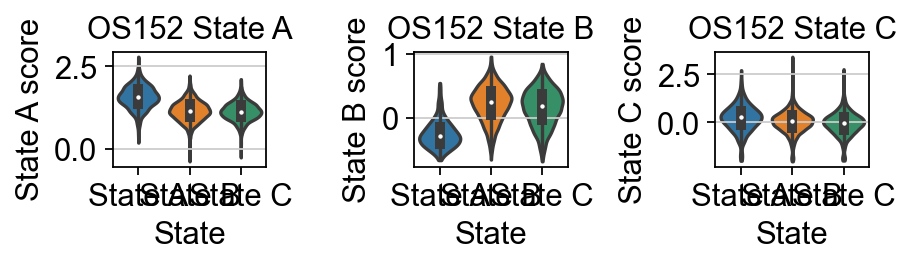

In [3]:
# Reading in gene lists for GSEA
Subtype_A_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/State_A_module_NMF.csv')]
Subtype_B_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/State_B_module_NMF.csv')]
Subtype_C_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/State_C_module_NMF.csv')]


# Keeping only genes that appear in the adata
Subtype_A_genes = [x for x in Subtype_A_genes if x in adata.var_names]
Subtype_B_genes = [x for x in Subtype_B_genes if x in adata.var_names]
Subtype_C_genes = [x for x in Subtype_C_genes if x in adata.var_names]


# Computing GSEA scores
sc.tl.score_genes(adata, Subtype_A_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='State_A_score', random_state=0, copy=False, use_raw=None)

sc.tl.score_genes(adata, Subtype_B_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='State_B_score', random_state=0, copy=False, use_raw=None)

sc.tl.score_genes(adata, Subtype_C_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='State_C_score', random_state=0, copy=False, use_raw=None)

# Plotting the results
fig, axs = plt.subplots(1, 3, figsize=(5.7, 1.9))


sc.pl.violin(adata, ['State_A_score'], 
             groupby='State', stripplot=False, inner='box', 
             ylabel='State A score', ax=axs[0], show=False)

axs[0].set_title('OS152 State A')

sc.pl.violin(adata, ['State_B_score'], 
             groupby='State', stripplot=False, inner='box', 
             ylabel='State B score', ax=axs[1], show=False)

axs[1].set_title('OS152 State B')

sc.pl.violin(adata, ['State_C_score'], 
             groupby='State', stripplot=False, inner='box', 
             ylabel='State C score', ax=axs[2], show=False)

axs[2].set_title('OS152 State C')


plt.tight_layout()


# Saving the figure onto the desktop
plt.savefig('/Users/brendamelano/Desktop/OS152_state_module_scores.svg', format='svg')
plt.show()

computing score 'State_A_score'
    finished: added
    'State_A_score', score of gene set (adata.obs).
    99 total control genes are used. (0:00:00)
computing score 'Subtype_B_score'
    finished: added
    'Subtype_B_score', score of gene set (adata.obs).
    248 total control genes are used. (0:00:00)
computing score 'Subtype_C_score'
    finished: added
    'Subtype_C_score', score of gene set (adata.obs).
    49 total control genes are used. (0:00:00)


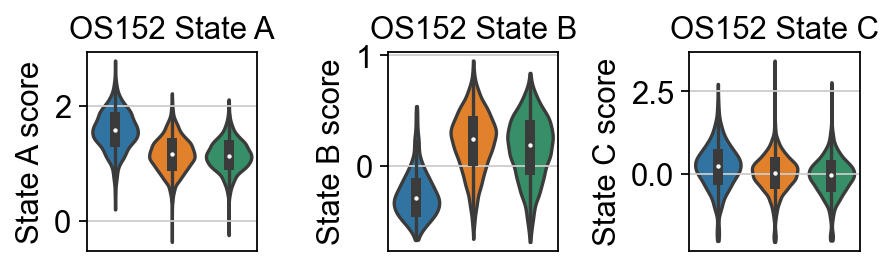

In [5]:
# Reading in gene lists for GSEA
Subtype_A_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/State_A_module_NMF.csv')]
Subtype_B_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/State_B_module_NMF.csv')]
Subtype_C_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/State_C_module_NMF.csv')]


# Keeping only genes that appear in the adata
Subtype_A_genes = [x for x in Subtype_A_genes if x in adata.var_names]
Subtype_B_genes = [x for x in Subtype_B_genes if x in adata.var_names]
Subtype_C_genes = [x for x in Subtype_C_genes if x in adata.var_names]


# Computing GSEA scores
sc.tl.score_genes(adata, Subtype_A_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='State_A_score', random_state=0, copy=False, use_raw=None)

sc.tl.score_genes(adata, Subtype_B_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='Subtype_B_score', random_state=0, copy=False, use_raw=None)

sc.tl.score_genes(adata, Subtype_C_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='Subtype_C_score', random_state=0, copy=False, use_raw=None)

# Plotting the results
fig, axs = plt.subplots(1, 3, figsize=(5.7, 1.9))

sc.pl.violin(adata, ['State_A_score'], 
             groupby='State', stripplot=False, inner='box', 
             ylabel='State A score', ax=axs[0], show=False)
axs[0].set_title('OS152 State A')

sc.pl.violin(adata, ['Subtype_B_score'], 
             groupby='State', stripplot=False, inner='box', 
             ylabel='State B score', ax=axs[1], show=False)
axs[1].set_title('OS152 State B')

sc.pl.violin(adata, ['Subtype_C_score'], 
             groupby='State', stripplot=False, inner='box', 
             ylabel='State C score', ax=axs[2], show=False)
axs[2].set_title('OS152 State C')

# Remove x-axis labels and tick labels
for ax in axs:
    ax.set_xlabel('')  # Remove x-axis labels
    ax.set_xticks([])  # Remove x-axis tick labels

plt.tight_layout()

# Saving the figure onto the desktop
plt.savefig('/Users/brendamelano/Desktop/OS152_state_module_scores.svg', format='svg')
plt.show()


# Plotting markers by subtype

<Figure size 1200x300 with 0 Axes>

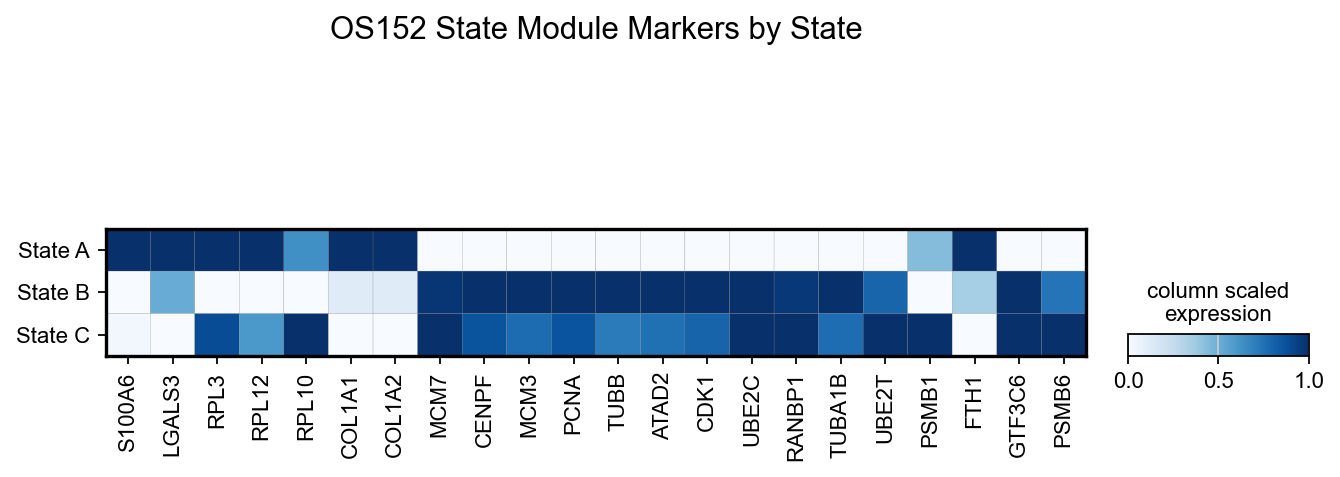

In [10]:
# Creating a figure
plt.figure(figsize=(2, 0.5), dpi=600) 


# Plotting the matrix plot
ax = sc.pl.matrixplot(
    adata,
    var_names=combined_genes, 
    groupby='State',
    cmap="Blues",
    use_raw=True,
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
    title="OS152 State Module Markers by State",
    show=False
)


# Saving svg
plt.savefig("/Users/brendamelano/Desktop/OS152_subtype_markers.svg", format='svg')

plt.show()

plt.close()


# Plotting markers by cluster

In [6]:
Subtype_A_genes = pd.read_csv('/Users/brendamelano/Desktop/gmt_files/State_A_module_NMF.csv', header=0)


Subtype_A_genes = Subtype_A_genes.to_numpy()


# Convert the set of tuples back to a list of lists (if necessary)
Subtype_A_genes = [list(gene) for gene in Subtype_A_genes]


Subtype_A_genes = np.array(Subtype_A_genes).flatten()


# Convert the numpy array to a pandas DataFrame
Subtype_A_genes_df = pd.DataFrame(Subtype_A_genes, columns=['Gene'])

Subtype_A_genes = Subtype_A_genes_df['Gene']

Subtype_B_genes = pd.read_csv('/Users/brendamelano/Desktop/gmt_files/State_B_module_NMF.csv', header=0)


Subtype_B_genes = Subtype_B_genes.to_numpy()


# Convert the set of tuples back to a list of lists (if necessary)
Subtype_B_genes = [list(gene) for gene in Subtype_B_genes]


Subtype_B_genes = np.array(Subtype_B_genes).flatten()



# Convert the numpy array to a pandas DataFrame
Subtype_B_genes_df = pd.DataFrame(Subtype_B_genes, columns=['Gene'])

Subtype_B_genes = Subtype_B_genes_df['Gene']

Subtype_C_genes = pd.read_csv('/Users/brendamelano/Desktop/gmt_files/State_C_module_NMF.csv', header=0)


Subtype_C_genes = Subtype_C_genes.to_numpy()


# Convert the set of tuples back to a list of lists (if necessary)
Subtype_C_genes = [list(gene) for gene in Subtype_C_genes]


Subtype_C_genes = np.array(Subtype_C_genes).flatten()



# Convert the numpy array to a pandas DataFrame
Subtype_C_genes_df = pd.DataFrame(Subtype_C_genes, columns=['Gene'])

Subtype_C_genes = Subtype_C_genes_df['Gene']

In [7]:
# Function to process gene files through the pipeline
def process_genes(file_path):
    # Read file into a DataFrame
    genes = pd.read_csv(file_path, header=0)

    # Convert DataFrame to numpy array
    genes_array = genes.to_numpy()

    # Convert tuples to lists
    genes_list = [list(gene) for gene in genes_array]

    # Flatten the list of lists into a numpy array
    genes_flattened = np.array(genes_list).flatten()

    # Convert numpy array to a pandas DataFrame
    genes_df = pd.DataFrame(genes_flattened, columns=['Gene'])

    return genes_df


# File paths for gene modules
file_paths = {
    "A": '/Users/brendamelano/Desktop/gmt_files/State_A_module_NMF.csv',
    "B": '/Users/brendamelano/Desktop/gmt_files/State_B_module_NMF.csv',
    "C": '/Users/brendamelano/Desktop/gmt_files/State_C_module_NMF.csv',
}


# Process each state and store results
processed_genes = {}
for key, path in file_paths.items():
    if os.path.exists(path):
        processed_genes[key] = process_genes(path)
    else:
        print(f"Skipping State {key} due to missing file.")

        
# Output processed gene data for each subtype
for key, df in processed_genes.items():
    print(f"\nProcessed genes for Subtype {key}:")
    print(df)
    
    
# Concatenate all DataFrames into a single DataFrame
combined_genes_df = pd.concat(processed_genes.values(), ignore_index=True)


# PRinting the combined genes
print("\nCombined genes DataFrame:")
print(combined_genes_df)


Processed genes for Subtype A:
     Gene
0  S100A6
1  LGALS3
2    RPL3
3   RPL12
4   RPL10
5  COL1A1
6  COL1A2

Processed genes for Subtype B:
      Gene
0     MCM7
1    CENPF
2     MCM3
3     PCNA
4     TUBB
5    ATAD2
6     CDK1
7    UBE2C
8   RANBP1
9   TUBA1B
10   UBE2T

Processed genes for Subtype C:
     Gene
0   PSMB1
1    FTH1
2  GTF3C6
3   PSMB6

Combined genes DataFrame:
      Gene
0   S100A6
1   LGALS3
2     RPL3
3    RPL12
4    RPL10
5   COL1A1
6   COL1A2
7     MCM7
8    CENPF
9     MCM3
10    PCNA
11    TUBB
12   ATAD2
13    CDK1
14   UBE2C
15  RANBP1
16  TUBA1B
17   UBE2T
18   PSMB1
19    FTH1
20  GTF3C6
21   PSMB6


In [8]:
# Keeping only genes that appear in the adata object
combined_genes = [gene for gene in combined_genes_df['Gene'] if gene in adata.raw.var_names]



In [3]:

# Ensure the combined_genes are in the expression data
#adata_subset = adata.raw[:, adata.raw.var_names.isin(combined_genes_df['Gene'])]



# Create a list of genes sorted by subtype for use in the matrixplot
#sorted_genes_by_subtype = adata_subset.var_names.tolist()


# Creating a figure
plt.figure(figsize=(10, 5), dpi=600) 


ax = sc.pl.matrixplot(
    adata,
    var_names=combined_genes_df['Gene'],  # Use the sorted list of genes
    groupby='leiden',
    cmap="Reds",
    use_raw=True,
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
    title="OS152 State Module Markers by Cluster",
    show=False
)


# Save the figure using matplotlib's savefig with explicit format setting
plt.savefig("/Users/brendamelano/Desktop/OS152_cluster_markers.svg", format='svg')

plt.show()

plt.close()


NameError: name 'combined_genes_df' is not defined

<Figure size 6000x3000 with 0 Axes>

# Pathway enrichment analysis

computing score 'IL2_genes_score'
    finished: added
    'IL2_genes_score', score of gene set (adata.obs).
    148 total control genes are used. (0:00:00)
computing score 'MTOR_genes_score'
    finished: added
    'MTOR_genes_score', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)
computing score 'FOCAL_ADHESION_PI3KAKTMTOR_genes_score'
    finished: added
    'FOCAL_ADHESION_PI3KAKTMTOR_genes_score', score of gene set (adata.obs).
    196 total control genes are used. (0:00:00)
computing score 'PDGF_ERK1_DOWN_genes_score'
    finished: added
    'PDGF_ERK1_DOWN_genes_score', score of gene set (adata.obs).
    197 total control genes are used. (0:00:00)
computing score 'TNFA_genes_score'
    finished: added
    'TNFA_genes_score', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)
computing score 'GCNP_genes_score'
    finished: added
    'GCNP_genes_score', score of gene set (adata.obs).
    198 total control genes are used. 

    finished: added
    'ESC_genes_score', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)
computing score 'STK33_genes_score'
    finished: added
    'STK33_genes_score', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)
computing score 'VEGFA_genes_score'
    finished: added
    'VEGFA_genes_score', score of gene set (adata.obs).
    192 total control genes are used. (0:00:00)
computing score 'KRAS_genes_score'
    finished: added
    'KRAS_genes_score', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)
computing score 'TGFB_genes_score'
    finished: added
    'TGFB_genes_score', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)
computing score 'EMT_genes_score'
    finished: added
    'EMT_genes_score', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)
computing score 'EZH2_genes_score'
    finished: added
    'EZH2_genes_score', score o

    finished: added
    'LEF1_genes_score', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)


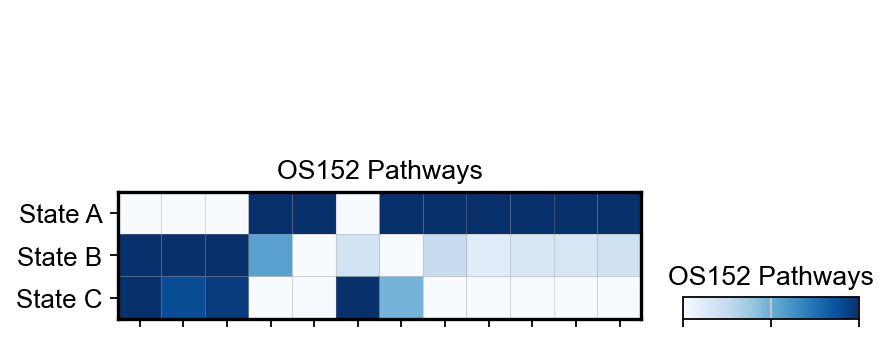

In [4]:
# Define the directory for the gmt files
directory = '/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/gmt_files'


# Create a dictionary to store gene lists
gene_lists = {}


# Create variables for gene lists
for filename in os.listdir(directory):
    
    # identifying the txt files
    if filename.endswith('.txt'):
        variable_name = os.path.splitext(filename)[0].upper()
        variable_name += "_genes"
        with open(os.path.join(directory, filename)) as f:
            gene_lists[variable_name] = [line.strip() for line in f]

            
# Create a dictionary to store gene scores for each module
gene_scores = {}


# Quantify enrichment for each gene list
for gene_list_name, gene_list in gene_lists.items():
    scores_key = gene_list_name + "_score"
    try:
        gene_scores[gene_list_name] = sc.tl.score_genes(
            adata, gene_list, ctrl_size=50, gene_pool=None,
            n_bins=5, score_name=scores_key, random_state=0, 
            copy=False, use_raw=None
        )
    except KeyError:
        continue

        
adata.var_names_make_unique()


# Defining the score names
scores = ['MTOR_genes_score', 'GCNP_genes_score', 'CSR_genes_score',   
          'LEF1_genes_score','ESC_genes_score','TNFA_genes_score',
          'PDGF_ERK1_DOWN_genes_score', 'KRAS_genes_score', 'TGFB_genes_score',
          'IL2_genes_score',  'FOCAL_ADHESION_PI3KAKTMTOR_genes_score', 'STK33_genes_score',]


# Plotting the pathway matrix plot based on subtype
axes_dict = sc.pl.matrixplot(
    adata,
    scores,
    "State",
    dendrogram=False,
    cmap="Blues",
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
    show=False  # This prevents the plot from showing immediately
)


# Remove the x-axis labels
for ax in axes_dict.values():
    ax.set_xticklabels([])  # Remove x-axis labels
    ax.set_title('OS152 Pathways', fontsize=12)

    
# Save the figure. Ensure that all parts of the figure are on the same figure object
plt.gcf().savefig('/Users/brendamelano/Desktop/OS152_Pathways.svg', format='svg')  # Adjust path as needed


# Show the plot if desired
plt.show()

# CellRank

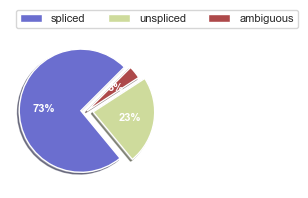

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/6490 [00:00<?, ?cell/s]

  0%|          | 0/6490 [00:00<?, ?cell/s]

GPCCA[kernel=(0.8 * VelocityKernel[n=6490] + 0.2 * ConnectivityKernel[n=6490]), initial_states=None, terminal_states=None]


In [10]:
# Computing proportions of spliced and unspliced RNA
scv.pl.proportions(adata)


# Setting up the velocity kernel
vk = cr.kernels.VelocityKernel(adata)


# Compute the transition matrix
vk.compute_transition_matrix()


# combining the velocity and connectivity kernel
ck = cr.kernels.ConnectivityKernel(adata)
ck.compute_transition_matrix()


# Combining the velocity kernel with the connectivity kernel
combined_kernel = .8 * vk + 0.2 * ck


# Setting up the gPCCA estmator
g = GPCCA(combined_kernel)
print(g)

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/plotting/utils.py:1391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/plotting/utils.py:1392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c=gp_color, zorder=zord - 1, **kwargs)
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/c

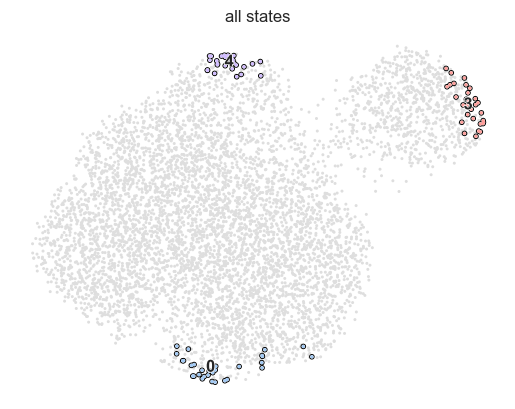

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/plotting/utils.py:1391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/plotting/utils.py:1392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c=gp_color, zorder=zord - 1, **kwargs)
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/c

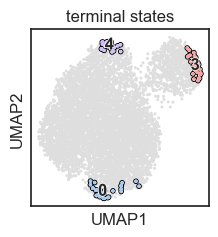

Defaulting to `'gmres'` solver.


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/3 [00:00<?, ?/s]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


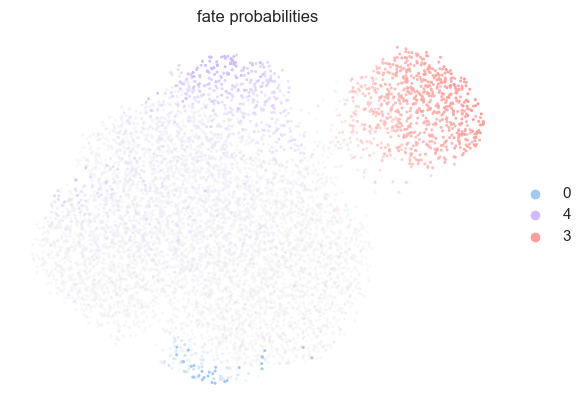

In [11]:

g.fit(n_states=3, cluster_key="leiden")
g.plot_macrostates(which="all")

g.predict_terminal_states(method="top_n", n_states=3)


# Creating a figure
fig, ax = plt.subplots(figsize=(2.3, 2.3))


# Plot macrostates with rasterization
g.plot_macrostates(which="terminal", ax=ax, frameon=True, rasterized=True)


# Set the title with a custom font
ax.set_title("OS152 Terminal states", fontsize=10)


# Save the plot as SVG
#fig.savefig("/Users/brendamelano/Desktop/OS384_terminal_states.svg", format='svg', dpi=300)


# Computing fate probabilities
g.compute_fate_probabilities()
g.plot_fate_probabilities(legend_loc="right")

# State labeling

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


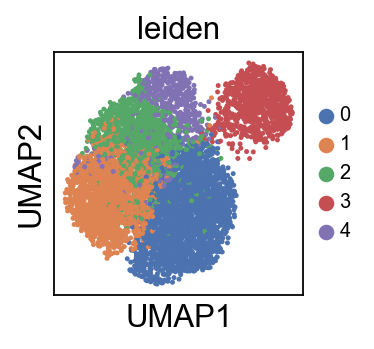

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


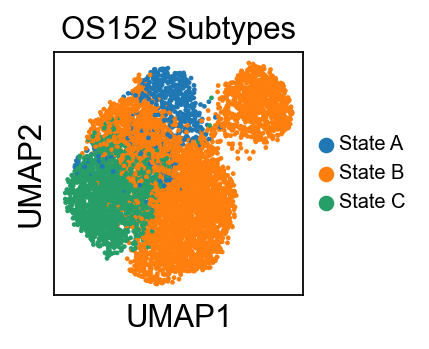

In [3]:
# Generating umap to visualize clusters
sc.pl.umap(adata, color=['leiden'], 
           legend_fontsize=9, 
           size = 20)

adata.obs['leiden'] = adata.obs['leiden'].astype('category')


adata.obs['leiden'][adata.obs['leiden']=='3']='2'
adata.obs['leiden'][adata.obs['leiden']=='0']='2'


# adding labels for trajectory subtype
# Fill in the clusters that belong to each cell type based on each marker in the plot above
cell_dict = { 'State A': ['4'],  'State B': ['2'], 'State C':['1']}


# Initialize empty column in cell metadata
adata.obs['State'] = np.nan


# Generate new assignments
for i in cell_dict.keys():
    ind = pd.Series(adata.obs.leiden).isin(cell_dict[i])
    adata.obs.loc[ind,'State'] = i

    
# Creating a dataframe with the cluster IDs
states = pd.DataFrame(adata.obs['State'].values)


# Define the number of clusters
n_states = len(states[0].unique())


# Define a color palette with a limited number of colors
colors = sns.color_palette('pastel', n_states)


sc.pl.umap(adata, color=['State'], legend_fontsize=9, title = "OS152 States") #, palette = subtype_colors



In [13]:
# saving the adata file with the cluster ids
adata.write("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS152/OS152_adata_subtype_PCA.h5ad")


# DGEA by state

In [3]:
# Performing DGEA between clusters
sc.tl.rank_genes_groups(adata, 'State', method='wilcoxon')


# Creating a df for the cluster specific markers
state_markers = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(60)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)


In [4]:
# Try to set this equal to the column that contains COL1A1 to automate it
cluster_id = 'State A' 


# Making a df for the gene names
genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'][cluster_id]).head(60)
p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'][cluster_id]).head(60)
adjusted_p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'][cluster_id]).head(60)
log_fold_changes = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'][cluster_id]).head(60)
scores = pd.DataFrame(adata.uns['rank_genes_groups']['scores'][cluster_id]).head(60)


# Combine into a single DataFrame
cluster_markers = pd.DataFrame({
    'genes': genes.values.flatten(),  # Ensure it's a 1D array
    'p_values': p_values.values.flatten(),
    'adjusted_p_values': adjusted_p_values.values.flatten(),
    'log_fold_changes': log_fold_changes.values.flatten(),
    'scores': scores.values.flatten()
})


# Sort the DataFrame by log_fold_changes in descending order
OS152_subtype_A_markers = cluster_markers.sort_values(by='log_fold_changes', ascending=False)


In [5]:
# Write the array to a CSV file
#np.savetxt("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS152_subtype_A_markers.csv", OS152_subtype_A_markers, delimiter=",", fmt='%s')


#OS152_subtype_A_markers = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS152_subtype_A_markers.csv', header=None)

#OS152_subtype_A_markers = OS152_subtype_A_markers.to_numpy()


OS384_subtype_A_markers = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384_State_A_markers_NMF.csv', header=None)


OS384_subtype_A_markers = OS384_subtype_A_markers.to_numpy()

OS742_subtype_A_markers = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS742_State_A_markers_NMF.csv', header=None)


OS742_subtype_A_markers = OS742_subtype_A_markers.to_numpy()


# Convert numpy arrays of arrays into sets of tuples
set1 = set(tuple(map(tuple, OS384_subtype_A_markers)))
set2 = set(tuple(map(tuple, OS742_subtype_A_markers)))
set3 = set(tuple(map(tuple, OS152_subtype_A_markers)))


# Find common genes that appear in two or more lists
State_A_common_genes = (set1 & set2) | (set2 & set3) | (set1 & set3)


# Convert the set of tuples back to a list of lists (if necessary)
common_genes_list = [list(gene) for gene in State_A_common_genes]

common_genes_list

common_genes_array = np.array(common_genes_list).flatten()

# Convert the numpy array to a pandas DataFrame
common_genes_df = pd.DataFrame(common_genes_array, columns=['Gene'])

common_genes_df

# Save the DataFrame to a CSV file
#common_genes_df.to_csv('/Users/brendamelano/Desktop/gmt_files/State_A_module_NMF.csv', index=False)

,Gene
0,RPL12
1,S100A6
2,COL1A2
3,RPL3
4,RPL10
5,LGALS3
6,COL1A1


In [12]:
common_genes_df

,Gene
0,S100A6
1,LGALS3
2,RPL3
3,RPL12
4,RPL10
5,COL1A1
6,COL1A2


# state B

In [19]:
# Try to set this equal to the column that contains COL1A1 to automate it
cluster_id = 'State B'  # Adjust based on your cluster of interest


# Making a df for the gene names
genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'][cluster_id]).head(60)
p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'][cluster_id]).head(60)
adjusted_p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'][cluster_id]).head(60)
log_fold_changes = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'][cluster_id]).head(60)
scores = pd.DataFrame(adata.uns['rank_genes_groups']['scores'][cluster_id]).head(60)


# Combine into a single DataFrame
cluster_markers = pd.DataFrame({
    'genes': genes.values.flatten(),  # Ensure it's a 1D array
    'p_values': p_values.values.flatten(),
    'adjusted_p_values': adjusted_p_values.values.flatten(),
    'log_fold_changes': log_fold_changes.values.flatten(),
    'scores': scores.values.flatten()
})


# Sort the DataFrame by log_fold_changes in descending order
OS152_subtype_B_markers = cluster_markers.sort_values(by='log_fold_changes', ascending=False)


In [20]:
# Write the array to a CSV file
#np.savetxt("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS152_subtype_A_markers.csv", OS152_subtype_A_markers, delimiter=",", fmt='%s')


#OS152_subtype_A_markers = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS152_subtype_A_markers.csv', header=None)

#OS152_subtype_A_markers = OS152_subtype_A_markers.to_numpy()


OS384_subtype_B_markers = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384_State_B_markers_NMF.csv', header=None)


OS384_subtype_B_markers = OS384_subtype_B_markers.to_numpy()

OS742_subtype_B_markers = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS742_State_B_markers_NMF.csv', header=None)


OS742_subtype_B_markers = OS742_subtype_B_markers.to_numpy()


# Convert numpy arrays of arrays into sets of tuples
set1 = set(tuple(map(tuple, OS384_subtype_B_markers)))
set2 = set(tuple(map(tuple, OS742_subtype_B_markers)))
set3 = set(tuple(map(tuple, OS152_subtype_B_markers)))


# Find common genes that appear in two or more lists
State_B_common_genes = (set1 & set2) | (set2 & set3) | (set1 & set3)

# Convert the set of tuples back to a list of lists (if necessary)
common_genes_list = [list(gene) for gene in State_B_common_genes]

common_genes_list

common_genes_array = np.array(common_genes_list).flatten()

# Convert the numpy array to a pandas DataFrame
common_genes_df = pd.DataFrame(common_genes_array, columns=['Gene'])



# Save the DataFrame to a CSV file
common_genes_df.to_csv('/Users/brendamelano/Desktop/gmt_files/State_B_module_NMF.csv', index=False)

common_genes_df

,Gene
0,MCM7
1,CENPF
2,MCM3
3,PCNA
4,TUBB
5,ATAD2
6,CDK1
7,UBE2C
8,RANBP1
9,TUBA1B


# State C

In [6]:
# Try to set this equal to the column that contains COL1A1 to automate it
cluster_id = 'State C'  # Adjust based on your cluster of interest


# Making a df for the gene names
genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'][cluster_id]).head(60)
p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'][cluster_id]).head(60)
adjusted_p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'][cluster_id]).head(60)
log_fold_changes = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'][cluster_id]).head(60)
scores = pd.DataFrame(adata.uns['rank_genes_groups']['scores'][cluster_id]).head(60)


# Combine into a single DataFrame
cluster_markers = pd.DataFrame({
    'genes': genes.values.flatten(),  # Ensure it's a 1D array
    'p_values': p_values.values.flatten(),
    'adjusted_p_values': adjusted_p_values.values.flatten(),
    'log_fold_changes': log_fold_changes.values.flatten(),
    'scores': scores.values.flatten()
})


# Sort the DataFrame by log_fold_changes in descending order
OS152_subtype_C_markers = cluster_markers.sort_values(by='log_fold_changes', ascending=False)


In [36]:
OS152_subtype_C_markers

,genes,p_values,adjusted_p_values,log_fold_changes,scores
12,GAL,7.462952e-64,3.316453e-61,1.478498,16.870132
54,CYBA,1.239966e-25,1.153312e-23,1.342984,10.465821
19,BARX1,2.097824e-49,5.786377e-47,1.038343,14.775822
5,NPW,6.878345e-100,7.834329e-97,1.028060,21.215437
24,CIBAR1,2.069502e-45,4.474039e-43,0.966577,14.142778
20,MAGOH,6.815926e-48,1.703769e-45,0.550615,14.539429
16,ATP5PB,1.655981e-53,5.519248e-51,0.549113,15.399242
45,PTTG1,3.234018e-28,3.543686e-26,0.538806,11.015038
36,UBE2S,4.443767e-37,6.835710e-35,0.513660,12.722336
18,LAMTOR5,8.342501e-52,2.566603e-49,0.457031,15.143670


In [7]:

# Write the array to a CSV file
#np.savetxt("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS152_subtype_A_markers.csv", OS152_subtype_C_markers, delimiter=",", fmt='%s')


#OS152_subtype_C_markers = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS152_subtype_C_markers.csv', header=None)

#OS152_subtype_C_markers = OS152_subtype_C_markers.to_numpy()


OS384_subtype_C_markers = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384_State_C_markers_NMF.csv', header=None)


OS384_subtype_C_markers = OS384_subtype_C_markers.to_numpy()

OS742_subtype_C_markers = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS742_State_C_markers_NMF.csv', header=None)


OS742_subtype_C_markers = OS742_subtype_C_markers.to_numpy()


# Convert numpy arrays of arrays into sets of tuples
set1 = set(tuple(map(tuple, OS384_subtype_C_markers)))
set2 = set(tuple(map(tuple, OS742_subtype_C_markers)))
set3 = set(tuple(map(tuple, OS152_subtype_C_markers)))


# Find common genes that appear in two or more lists
State_C_common_genes = (set1 & set2) | (set2 & set3) | (set1 & set3)

# Convert the set of tuples back to a list of lists (if necessary)
common_genes_list = [list(gene) for gene in State_C_common_genes]

common_genes_list

common_genes_array = np.array(common_genes_list).flatten()

# Convert the numpy array to a pandas DataFrame
common_genes_df = pd.DataFrame(common_genes_array, columns=['Gene'])



# Save the DataFrame to a CSV file
#common_genes_df.to_csv('/Users/brendamelano/Desktop/gmt_files/State_C_module_NMF.csv', index=False)

common_genes_df


,Gene
0,PSMB6
1,GTF3C6
2,PSMB1
3,FTH1


,Gene
0,PSMB6
1,PSMB1
2,GTF3C6
3,FTH1


In [ ]:
# Read gene lists for each subtype from the CSV files
def read_genes(file_path):
    import pandas as pd
    genes_df = pd.read_csv(file_path, header=0)  # Assuming the header is on the first row
    genes = genes_df.iloc[:, 0].tolist()  # Get the first column as a list
    return genes


# Reading in the subtype gene modules
Subtype_A_genes = read_genes('/Users/brendamelano/Desktop/gmt_files/State_A_module_NMF.csv')
Subtype_B_genes = read_genes('/Users/brendamelano/Desktop/gmt_files/State_B_module_NMF.csv')
Subtype_C_genes = read_genes('/Users/brendamelano/Desktop/gmt_files/State_C_module_NMF.csv')


In [43]:
missing_genes = [gene for gene in common_genes_df['Gene'] if gene not in adata.raw.var_names]
missing_genes


Genes not found in adata.var_names: []


In [4]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import kruskal

def plot_facet_gene_expression(adata, gene_list, output_file, cell_line, significance_threshold=0.05):
    """
    Quantify and visualize the expression of specified genes as a facet plot across different states.
    Applies FDR correction for multiple testing.

    Parameters:
    - adata: AnnData object containing single-cell data.
    - gene_list: List of gene names to quantify and plot.
    - output_file: Path to save the resulting facet plot.
    - cell_line: String specifying the cell line name to include in plot titles.
    - significance_threshold: FDR threshold for significance (default is 0.05).
    """
    # Filter genes to keep only those present in the dataset
    genes_in_data = [gene for gene in gene_list if gene in adata.var_names]
    genes_not_found = [gene for gene in gene_list if gene not in adata.var_names]

    if genes_not_found:
        print(f"The following genes were not found in the dataset and will be skipped: {', '.join(genes_not_found)}")
    
    if not genes_in_data:
        print("None of the specified genes are present in the dataset.")
        return

    # List to store p-values for correction
    p_values = []

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame()

    # Calculate mean expression and perform tests for each gene
    for gene in genes_in_data:
        # Extract the gene expression data
        gene_data = adata[:, gene].X.toarray().flatten()  # Get the gene expression vector

        # Create a DataFrame with state, gene name, and expression data
        gene_df = pd.DataFrame({
            'State': adata.obs['State'],
            'Expression': gene_data,
            'Gene': gene
        })

        # Append the gene-specific data to the main plot_df
        plot_df = pd.concat([plot_df, gene_df], axis=0)

        # Perform Kruskal-Wallis test (non-parametric alternative to ANOVA)
        _, p_value = kruskal(*[gene_df.loc[gene_df['State'] == state, 'Expression'] for state in gene_df['State'].unique()])
        p_values.append(p_value)

    # Step 2: Apply Benjamini-Hochberg (BH) correction
    _, corrected_pvals, _, _ = multipletests(p_values, alpha=significance_threshold, method='fdr_bh')

    # Step 3: Add corrected p-values to the DataFrame
    pval_dict = dict(zip(genes_in_data, corrected_pvals))
    plot_df['Corrected p-value'] = plot_df['Gene'].map(pval_dict)

    # Step 4: Create the facet plot
    g = sns.FacetGrid(plot_df, col='Gene', col_wrap=2, sharey=False, height=3, aspect=1.3)
    g.map(sns.barplot, 'State', 'Expression', palette='Set2', edgecolor='black')

    # Customize plot appearance
    for ax, gene in zip(g.axes.flat, genes_in_data):
        # Annotate each plot with the corrected p-value
        pval = pval_dict[gene]
        significance_label = "Significant" if pval < significance_threshold else "Not Significant"
        ax.text(0.95, 0.95, f'FDR p = {pval:.2e} ({significance_label})',
                horizontalalignment='right', verticalalignment='center', transform=ax.transAxes, fontsize=9)
        
        # Customize tick and label fonts
        ax.set_xlabel('')
        ax.set_ylabel(f'{gene} Expression', fontsize=9)
        ax.tick_params(axis='x', labelsize=9)
        ax.tick_params(axis='y', labelsize=9)
        ax.set_title(f"{cell_line} - {gene}", fontsize=9)

    # Set overall plot labels and layout
    g.set_titles(col_template="{col_name}", fontsize=9)
    g.set_xlabels("State", fontsize=9)
    g.set_ylabels("Expression", fontsize=9)
    g.fig.suptitle(f"{cell_line} Gene Expression Across States", y=1.05, fontsize=12)
    g.fig.tight_layout()

    # Save the facet plot
    plt.savefig(output_file, format='svg', dpi=300)
    plt.close()
    print(f"Facet plot saved to {output_file}")

# Example Usage
# Path to save the output plot
output_file = '/Users/brendamelano/Desktop/OS152_drivers_expression_facet.svg'

# Specify the cell line name
cell_line = 'OS152'


# Gene list
gene_list = ['DDIT3', 'TSHZ2', 'STAT1', 'NR0B1', 'NFE2L3', 'TCF4', 'NFKB2', 'IRF1', 'ZIC2', 'KLF12', 'JUNB', 'JUN']


# Call the function to generate the facet plot
plot_facet_gene_expression(adata, gene_list, output_file, cell_line)

The following genes were not found in the dataset and will be skipped: TSHZ2, STAT1, NR0B1, NFE2L3, NFKB2, KLF12, JUNB


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


Facet plot saved to /Users/brendamelano/Desktop/OS152_drivers_expression_facet.svg


# Exporting tsv with cell barcode and state for MAVE

In [4]:
def generate_tsv_from_anndata(adata, tsv_output_path, meta_col="State"):
    # Use adata.obs.index for barcodes
    barcodes = adata.obs.index
    
    # Clean the barcodes to remove prefix and suffix and add '-1' suffix
    barcodes = barcodes.str.replace(r'^OS152:', '', regex=True).str.replace(r'x$', '', regex=True) + '-1'
    
    # isolating the state column into a cell_type vector
    cell_types = adata.obs[meta_col]
    df = pd.DataFrame({'Barcode': barcodes, meta_col: cell_types})
    df.to_csv(tsv_output_path, sep='\t', index=False)
    print(f"TSV file saved to {tsv_output_path}")
    
    
# Defining the directory in which to save the tsv
tsv_output_path = "/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS152/OS152_10Xbarcode_state.tsv"
generate_tsv_from_anndata(adata, tsv_output_path)


tsv_output_path = "/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS152/OS152_10Xbarcode_state.tsv"


TSV file saved to /Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS152/OS152_10Xbarcode_state.tsv


In [16]:

# Read the TSV file into a DataFrame
df = pd.read_csv(tsv_output_path, sep='\t')
df

def split_bam(bamobj, dict_cells):
    dict_barcodes = {}
    for celltype in dict_cells.keys():
        print(f"Extracting {celltype} barcodes")
        barcodes = dict_cells[celltype]["barcodes"]
        for barcode in barcodes:
            dict_barcodes[barcode] = celltype
    barcodes = np.array(list(dict_barcodes.keys()))
    numreads = 0
    numaddedreads = 0
    for read in bamobj:
        cellbarcode = "0"
        for k in range(len(read.tags)):
            if read.tags[k][0] == "CB":
                cellbarcode = read.tags[k][1]
        if cellbarcode != "0":
            barcode_exists = cellbarcode in barcodes
            good_qual = read.mapq > 10
            if barcode_exists and good_qual:
                celltype = dict_barcodes[cellbarcode]
                dict_cells[celltype]["bamobj"].write(read)
                numaddedreads += 1
        if numreads % 500000 == 0:
            print(f"{numreads} reads analyzed, {numaddedreads} added")
        numreads += 1

def main(bampath, outdir, barcodepath, meta_col, samplename):
    bamobj = pysam.AlignmentFile(bampath, "rb")
    metadf = pd.read_csv(barcodepath, sep="\t")
    metadf = metadf[metadf[meta_col] == samplename]
    adname = samplename.replace(" ", "_")
    outpath = os.path.join(outdir, f"{adname}.bam")
    adobj = pysam.AlignmentFile(outpath, "wb", template=bamobj)
    dict_cells = {
        samplename: {
            "barcodes": np.array(metadf["Barcode"]),
            "bampath": outpath,
            "bamobj": adobj}}
    split_bam(bamobj, dict_cells)
    for celltype in pd.unique(metadf[meta_col]):
        dict_cells[celltype]["bamobj"].close()
    bamobj.close()
    
BAMPATH = "/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS152/possorted_genome_bam.bam" #"~/plain_osteo_scRNAseq/os_pdx/OS152/outs/possorted_genome_bam.bam"
OUTDIR = "/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS152/"#"~/plain_osteo_scRNAseq/os_pdx/OS152/outs"
BARCODEPATH = "/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS152/OS152_10Xbarcode_subtype.tsv"#"~/plain_osteo_scRNAseq/os_pdx/OS152/outs/OS152_10Xbarcode_subtype.tsv"
Subtypes = ["State A", "State B", "State C"]


for CELLTYPE in Subtypes:
    main(BAMPATH, OUTDIR, BARCODEPATH, "State", CELLTYPE)

TSV file saved to /Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS152/OS152_10Xbarcode_subtype.tsv
Extracting State A barcodes
0 reads analyzed, 0 added
500000 reads analyzed, 66903 added
1000000 reads analyzed, 140587 added
1500000 reads analyzed, 213847 added
2000000 reads analyzed, 288997 added
2500000 reads analyzed, 365009 added
3000000 reads analyzed, 437159 added
3500000 reads analyzed, 511669 added
4000000 reads analyzed, 586898 added
4500000 reads analyzed, 667740 added
5000000 reads analyzed, 744142 added
5500000 reads analyzed, 819839 added
6000000 reads analyzed, 892010 added
6500000 reads analyzed, 970523 added
7000000 reads analyzed, 1047288 added
7500000 reads analyzed, 1118493 added
8000000 reads analyzed, 1163047 added
8500000 reads analyzed, 1239919 added
9000000 reads analyzed, 1311111 added
9500000 reads analyzed, 1382471 added
10000000 reads analyzed, 1453098 added
10500000 reads analyzed, 1523521 added
11000000 reads analyzed, 1592

103000000 reads analyzed, 15337558 added
103500000 reads analyzed, 15417716 added
104000000 reads analyzed, 15496438 added
104500000 reads analyzed, 15570640 added
105000000 reads analyzed, 15646631 added
105500000 reads analyzed, 15724898 added
106000000 reads analyzed, 15803651 added
106500000 reads analyzed, 15883213 added
107000000 reads analyzed, 15958796 added
107500000 reads analyzed, 16039608 added
108000000 reads analyzed, 16111297 added
108500000 reads analyzed, 16175578 added
109000000 reads analyzed, 16241994 added
109500000 reads analyzed, 16313107 added
110000000 reads analyzed, 16383781 added
110500000 reads analyzed, 16454385 added
111000000 reads analyzed, 16527807 added
111500000 reads analyzed, 16599612 added
112000000 reads analyzed, 16671287 added
112500000 reads analyzed, 16742080 added
113000000 reads analyzed, 16814032 added
113500000 reads analyzed, 16884708 added
114000000 reads analyzed, 16956208 added
114500000 reads analyzed, 17029653 added
115000000 reads 

86000000 reads analyzed, 51327552 added
86500000 reads analyzed, 51633417 added
87000000 reads analyzed, 51939215 added
87500000 reads analyzed, 52130812 added
88000000 reads analyzed, 52429182 added
88500000 reads analyzed, 52737381 added
89000000 reads analyzed, 53031812 added
89500000 reads analyzed, 53326622 added
90000000 reads analyzed, 53622482 added
90500000 reads analyzed, 53920174 added
91000000 reads analyzed, 54223433 added
91500000 reads analyzed, 54530419 added
92000000 reads analyzed, 54829288 added
92500000 reads analyzed, 55125404 added
93000000 reads analyzed, 55428072 added
93500000 reads analyzed, 55731658 added
94000000 reads analyzed, 56038488 added
94500000 reads analyzed, 56310221 added
95000000 reads analyzed, 56607333 added
95500000 reads analyzed, 56919746 added
96000000 reads analyzed, 57201928 added
96500000 reads analyzed, 57505157 added
97000000 reads analyzed, 57799116 added
97500000 reads analyzed, 58103422 added
98000000 reads analyzed, 58403295 added


70000000 reads analyzed, 8593220 added
70500000 reads analyzed, 8658836 added
71000000 reads analyzed, 8722556 added
71500000 reads analyzed, 8786543 added
72000000 reads analyzed, 8852185 added
72500000 reads analyzed, 8918531 added
73000000 reads analyzed, 8976644 added
73500000 reads analyzed, 9032919 added
74000000 reads analyzed, 9098725 added
74500000 reads analyzed, 9161462 added
75000000 reads analyzed, 9224689 added
75500000 reads analyzed, 9290608 added
76000000 reads analyzed, 9342888 added
76500000 reads analyzed, 9399749 added
77000000 reads analyzed, 9450607 added
77500000 reads analyzed, 9505100 added
78000000 reads analyzed, 9560143 added
78500000 reads analyzed, 9611909 added
79000000 reads analyzed, 9665758 added
79500000 reads analyzed, 9721175 added
80000000 reads analyzed, 9772133 added
80500000 reads analyzed, 9827590 added
81000000 reads analyzed, 9888496 added
81500000 reads analyzed, 9942774 added
82000000 reads analyzed, 9993871 added
82500000 reads analyzed, 

In [3]:
import pysam

bam_files = [
    "/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS152/State_A.bam",
    "/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS152/State_B.bam",
    "/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS152/State_C.bam"
]

for bam_file in bam_files:
    pysam.index(bam_file)

# Chis-squared analysis for cell cycle

In [5]:
# Generate and save the first rasterized UMAP plot with fontsize 12
sc.pl.umap(
    adata,
    color=["phase"],
    frameon=True,
    title='OS152 Cell Cycle classification',
    show=False  # Prevent the plot from displaying in the interactive window
)

# Set tick label font sizes to 12 and adjust the title font size
fig = plt.gcf()
ax = plt.gca()

# Font size
ax.set_title(ax.get_title(), fontsize=12)


# Set axis labels and tick label font sizes
ax.set_xlabel(ax.get_xlabel(), fontsize=12)
ax.set_ylabel(ax.get_ylabel(), fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

# Ensure rasterization for compatibility
for collection in ax.collections:
    collection.set_rasterized(True)
fig.savefig("/Users/brendamelano/Desktop/OS152_phase_umap.svg", format='svg')
plt.close(fig)

# Generate and save the second rasterized UMAP plot with fontsize 12
sc.pl.umap(
    adata,
    color=["State_A_score"],
    frameon=True,
    title='OS152 State A Score UMAP',
    show=False
)

fig = plt.gcf()
ax = plt.gca()

# Set title and label font sizes
ax.set_title(ax.get_title(), fontsize=12)
ax.set_xlabel(ax.get_xlabel(), fontsize=12)
ax.set_ylabel(ax.get_ylabel(), fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

for collection in ax.collections:
    collection.set_rasterized(True)
fig.savefig("/Users/brendamelano/Desktop/OS152_state_A_score_umap.svg", format='svg')
plt.close(fig)

# Perform chi-squared analysis
# Small constant to avoid zero counts in the contingency table
epsilon = 1e-5
obs_data = adata.obs

# Create a contingency table
# Rows: phase status
# Columns: Inside or outside Subtype A
contingency_table = pd.DataFrame(
    [
        [
            ((obs_data['phase'] == 'G1') & (obs_data['State'] == 'State A')).sum(),  # True in Subtype A
            ((obs_data['phase'] == 'G1') & (obs_data['State'] != 'State A')).sum(),  # True outside Subtype A
        ],
        [
            ((obs_data['phase'] != 'G1') & (obs_data['State'] == 'State A')).sum(),  # False in Subtype A
            ((obs_data['phase'] != 'G1') & (obs_data['State'] != 'State A')).sum(),  # False outside Subtype A
        ],
    ],
    index=["Phase_G1", "Phase_other"],
    columns=["State A", "Other State"]
)

# Add small constant to avoid issues with zeros
contingency_table += epsilon

# Perform chi-squared test
chi2, p, _, _ = chi2_contingency(contingency_table)

# Set a significance threshold
significance_threshold = 0.05

# Check if the result is significant
is_significant = p < significance_threshold

print(contingency_table)
print(f"Chi2: {chi2}")
print(f"P-value: {p}")
print(f"Significant: {'Yes' if is_significant else 'No'}")

# Calculate the proportions of G1 cells within State A and outside of State A
Subtype_A_G1 = obs_data[(obs_data['State'] == 'State A') & (obs_data['phase'] == 'G1')]
Subtype_A_all = obs_data[obs_data['State'] == 'State A']

Subtype_B_C_G1 = obs_data[(obs_data['State'] != 'State A') & (obs_data['phase'] == 'G1')]
Subtype_B_C_all = obs_data[obs_data['State'] != 'State A']

prop_in_Subtype_A = len(Subtype_A_G1) / len(Subtype_A_all)
prop_outside_Subtype_A = len(Subtype_B_C_G1) / len(Subtype_B_C_all)


# Data to plot
categories = ['State A', 'States B and C']
proportions = [prop_in_Subtype_A, prop_outside_Subtype_A]


# Create and save the rasterized bar chart
plt.figure(figsize=(3.5, 3.5))
bars = plt.bar(categories, proportions, width=0.8, color=['#aec6cf', '#ffb6c1'])  # pastel blue and pink

# Add a border around the chart
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_color('black')

# Remove gridlines
plt.grid(False)

# Add labels and title
plt.ylabel('Proportion of cells in G1 state', fontsize=12)
plt.title('OS152 Proportion of G1 cells', fontsize=12)

# Add p-value to the top right of the plot
plt.text(1, max(proportions) * 0.95, f'p-value: {p:.2e}', ha='right', fontsize=12)

# Add value labels on each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval, f'{yval:.2%}', va='bottom', fontsize=12)  # va: vertical alignment, percentage formatting

plt.tight_layout()
plt.savefig("/Users/brendamelano/Desktop/OS152_G1_proportion.svg", format='svg')
plt.close()

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


               State A  Other State
Phase_G1     496.00001   1440.00001
Phase_other   33.00001   4521.00001
Chi2: 1121.2806099586257
P-value: 7.82898858965789e-246
Significant: Yes
